<a href="https://colab.research.google.com/github/sudama-Inc/GRIP-TheSparkFoundation-Internship/blob/main/GRIP_stockMarketPredictionusingNumericalandTextualAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Author - Sudama Sharma


*   Stock Market Prediction using Numerical and Textual Analysis Create a hybrid model for stock price or performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines. The stock to analyze and predict is SENSEX (S&P BSE SENSEX)

## Import the Important Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import re
from textblob import TextBlob

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
import lightgbm

In [ ]:
# For time stamps
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
columns=['Date','Category','News']
ndf = pd.read_csv("/content/drive/MyDrive/Datasets/india-news-headlines.csv", names=columns)
ndf.head()

,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [ ]:
ndf.drop([0], inplace=True)
ndf.drop('Category', axis = 1, inplace=True)
ndf.head(-5)

,Date,News
1,20010102,Status quo will not be disturbed at Ayodhya; s...
2,20010102,Fissures in Hurriyat over Pak visit
3,20010102,America's unwanted heading for India?
4,20010102,For bigwigs; it is destination Goa
5,20010102,Extra buses to clear tourist traffic
...,...,...
3424058,20201231,50 NRIs reach Singhu; offer help to farmers
3424059,20201231,Navjot Singh Sidhu tweets apology; says 'wore ...
3424060,20201231,Azim Premji organisation's name misused to che...
3424061,20201231,Get govt nod to probe officials: MP to agencies


## Common Dataset Exploration

In [ ]:
# Check for common information of the first datast
ndf["Date"] = pd.to_datetime(ndf["Date"],format='%Y%m%d')
ndf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3424067 entries, 1 to 3424067
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Date    datetime64[ns]
 1   News    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 78.4+ MB


In [ ]:
# Group the headlines for each day
ndf['News'] = ndf.groupby(['Date']).transform(lambda x : ' '.join(x)) 
ndf = ndf.drop_duplicates() 
ndf.reset_index(inplace=True,drop=True)

In [ ]:
ndf

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
7257,2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...
7259,2020-12-29,Man recovers charred remains of 'thief' from h...
7260,2020-12-30,Numerology Readings 30 December 2020: Predicti...


In [ ]:
# Check for any duplicated values
ndf.isnull().sum()

Date    0
News    0
dtype: int64

In [ ]:
!pip install yfinance --upgrade --no-cache-dir

Requirement already up-to-date: yfinance in /usr/local/lib/python3.7/dist-packages (0.1.63)


In [ ]:
import yfinance as yf
hisdf = yf.download('^BSESN', start='2015-01-01', end='2021-07-16')

[*********************100%***********************]  1 of 1 completed


In [ ]:
hisdf

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400
2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200
2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100
2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200
2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200
...,...,...,...,...,...,...
2021-07-09,52508.238281,52555.730469,52228.011719,52386.191406,52386.191406,6400
2021-07-12,52634.328125,52700.511719,52208.960938,52372.691406,52372.691406,24900
2021-07-13,52694.890625,52806.859375,52545.679688,52769.730469,52769.730469,7900


In [ ]:
hisdf.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [ ]:
hisdf.reset_index(inplace=True)
# hisdf.rename(columns={'Date': 'date'}, inplace = True)
hisdf.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200


In [ ]:
# Check for common information of the second dataset
hisdf["Date"]= pd.to_datetime(hisdf["Date"])
hisdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1605 entries, 0 to 1604
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1605 non-null   datetime64[ns]
 1   Open       1605 non-null   float64       
 2   High       1605 non-null   float64       
 3   Low        1605 non-null   float64       
 4   Close      1605 non-null   float64       
 5   Adj Close  1605 non-null   float64       
 6   Volume     1605 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 87.9 KB


In [ ]:
hisdf.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200


In [ ]:
hisdf.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1605.000000,1605.000000,1605.000000,1605.000000,1605.000000,1.605000e+03
mean,34210.056285,34372.024786,33963.293637,34162.430475,34162.430475,2.126479e+05
std,7090.996365,7117.064492,7038.332953,7083.186885,7083.186885,1.861519e+06
min,23060.390625,23142.960938,22494.609375,22951.830078,22951.830078,1.000000e+02
25%,28069.849609,28194.609375,27897.449219,28067.310547,28067.310547,1.020000e+04
50%,33685.859375,33865.949219,33482.808594,33690.089844,33690.089844,1.340000e+04
75%,38348.390625,38513.691406,38066.128906,38276.628906,38276.628906,1.840000e+04
max,53126.730469,53266.121094,52948.429688,53158.851562,53158.851562,3.181510e+07


In [ ]:
# Check for duplicated values
hisdf.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Text(0, 0.5, 'BSESN')

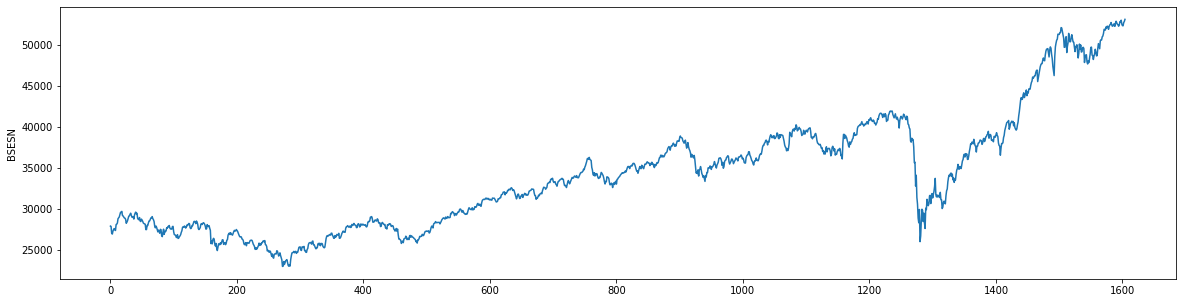

In [ ]:
# Figure plot
plt.figure(figsize=(20,5))
hisdf['Close'].plot()
plt.ylabel('BSESN')

## Remove Unwanted Characters from the News

In [ ]:
#removing unwanted characters from the News
ndf.replace("[^a-zA-Z']"," ",regex=True,inplace=True)
ndf["News"].head(5)

0    Status quo will not be disturbed at Ayodhya  s...
1    Powerless north India gropes in the dark Think...
2    The string that pulled Stephen Hawking to Indi...
3    Light combat craft takes India into club class...
4    Light combat craft takes India into club class...
Name: News, dtype: object

# Historical Analysis

### Plot the Moving Average

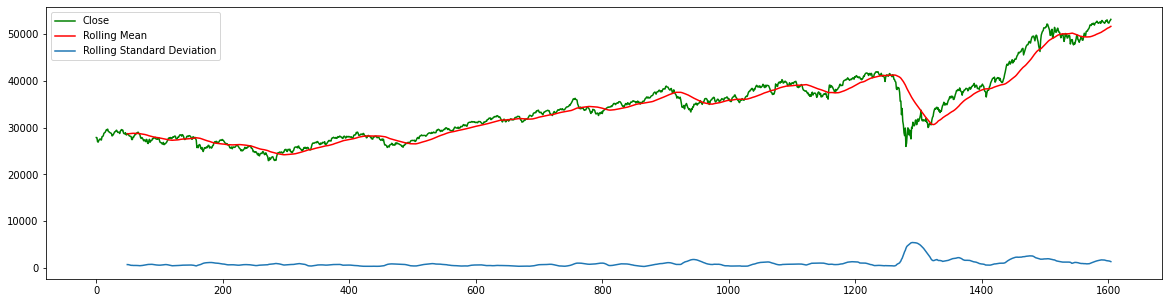

In [ ]:
#Plotting moving average
close = hisdf['Close']

ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(20,5))
hisdf['Close'].plot(color='g',label='Close')
ma.plot(color = 'r',label='Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')

plt.legend()

## Plot the Returns

Text(0.5, 1.0, 'Returns')

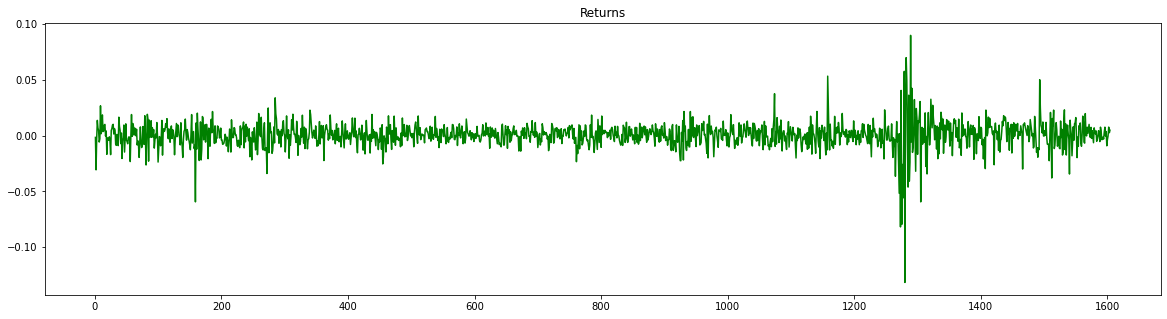

In [ ]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (20,5))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

###### have data length of 1605, so i take 1595:10

In [ ]:
# Train test split
train = hisdf[:1595]
test = hisdf[1595:]

## Rolling mean and Standard Deviation

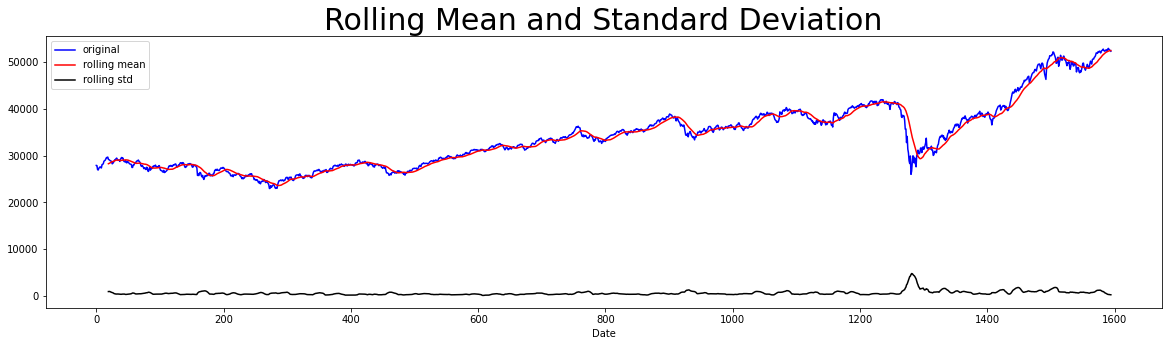

Results of dickey fuller test
ADF Test Statistic : 0.09696079796892444
p-value : 0.9658529800478364
#Lags Used : 11
Number of Observations Used : 1583
Weak evidence against null hypothesis, time series is non-stationary 


In [ ]:
from statsmodels.tsa.stattools import adfuller
#Stationarity test
def test_stationarity(timeseries):

 #Determine the rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (20,5))
 plt.plot(timeseries, color = 'blue', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'black', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 30)
 plt.show(block = False)
 
 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])

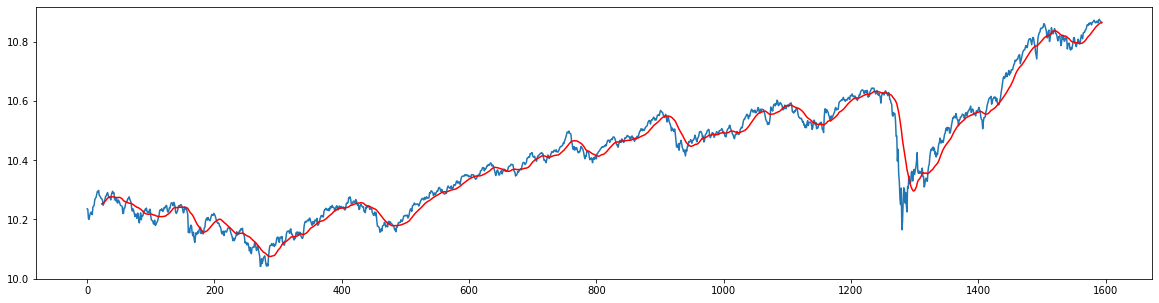

In [ ]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (20,5))
plt.plot(train_log) 
plt.plot(mav, color = 'red')

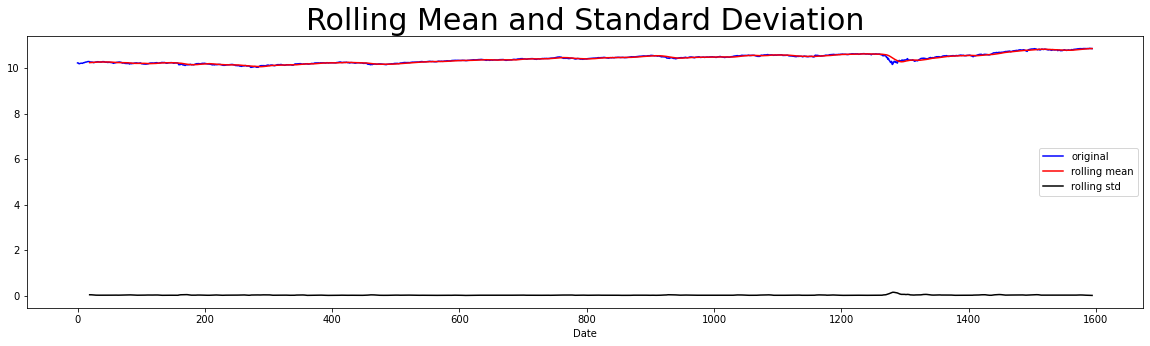

Results of dickey fuller test
ADF Test Statistic : -0.31010558047080705
p-value : 0.9240608351127462
#Lags Used : 11
Number of Observations Used : 1583
Weak evidence against null hypothesis, time series is non-stationary 


In [ ]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

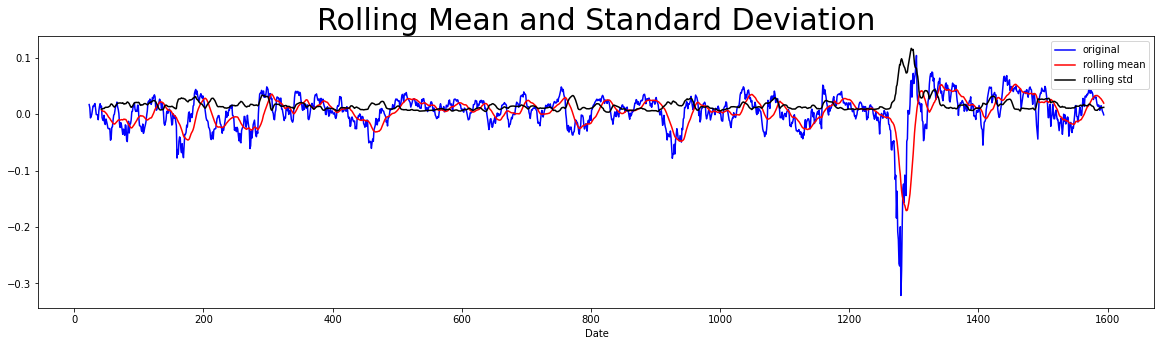

Results of dickey fuller test
ADF Test Statistic : -7.965074306380066
p-value : 2.8794975346204003e-12
#Lags Used : 12
Number of Observations Used : 1559
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [ ]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

In [ ]:
!pip install pmdarima

In [ ]:
#Using auto arima to make predictions using log data
from pmdarima import auto_arima

In [ ]:
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-9710.957, Time=1.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9716.444, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9716.593, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9716.527, Time=1.60 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9716.557, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-9714.923, Time=0.79 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9714.719, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-9712.941, Time=1.38 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-9716.564, Time=0.14 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 6.375 seconds


Text(0, 0.5, 'Actual Stock Price')

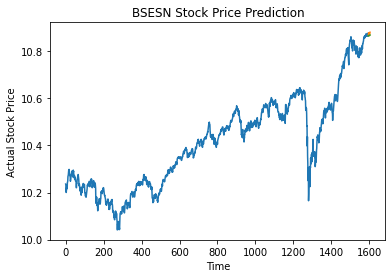

In [ ]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

# Error Calculation

In [ ]:
#Calculating error
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

RMSE :  0.007552852823666316


# Textual Analysis

In [ ]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [ ]:
#Adding subjectivity and polarity columns
ndf['Subjectivity'] = ndf['News'].apply(getSubjectivity)
ndf['Polarity'] = ndf['News'].apply(getPolarity)
ndf

,Date,News,Subjectivity,Polarity
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485
...,...,...,...,...
7257,2020-12-27,BigInterview Dhritiman Chatterjee Nobody da...,0.392082,0.042978
7258,2020-12-28,Horoscope Today December Check astro...,0.409973,0.071405
7259,2020-12-29,Man recovers charred remains of 'thief' from h...,0.415684,0.060775
7260,2020-12-30,Numerology Readings December Predicti...,0.436863,0.046930


In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [ ]:
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

In [ ]:
ndf['Compound'] = [sia.polarity_scores(v)['compound'] for v in ndf['News']]
ndf['Negative'] = [sia.polarity_scores(v)['neg'] for v in ndf['News']]
ndf['Neutral'] = [sia.polarity_scores(v)['neu'] for v in ndf['News']]
ndf['Positive'] = [sia.polarity_scores(v)['pos'] for v in ndf['News']]
ndf

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024,0.9365,0.142,0.696,0.161
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485,-0.8316,0.214,0.655,0.131
...,...,...,...,...,...,...,...,...
7257,2020-12-27,BigInterview Dhritiman Chatterjee Nobody da...,0.392082,0.042978,-0.9997,0.129,0.793,0.079
7258,2020-12-28,Horoscope Today December Check astro...,0.409973,0.071405,-0.9998,0.142,0.761,0.097
7259,2020-12-29,Man recovers charred remains of 'thief' from h...,0.415684,0.060775,-0.9999,0.151,0.753,0.096
7260,2020-12-30,Numerology Readings December Predicti...,0.436863,0.046930,-0.9999,0.146,0.770,0.084


# Merge the Historical and Textual Data

In [ ]:
df_merge = pd.merge(hisdf, ndf, how='inner', on='Date')
df_merge

,Date,Open,High,Low,Close,Adj Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400,Drink smart with these party tips How to say s...,0.454701,0.053671,-0.9997,0.149,0.735,0.116
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200,Recipe Strawberry cupcakes Recipe Kaju jeera...,0.429367,0.100463,-0.9990,0.131,0.756,0.113
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100,Turn to gardening for happiness Teeth jeweller...,0.388354,0.060982,-0.9997,0.116,0.805,0.079
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200,Can ex lovers be friends Is water diet bad fo...,0.386384,0.033056,-1.0000,0.171,0.741,0.087
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200,How to do a home manicure Recipe Spiced beetr...,0.406919,0.063963,-0.9999,0.143,0.776,0.081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469,2020-12-24,46743.488281,47053.398438,46539.019531,46973.539062,46973.539062,13700,How to set the mood for sex during cold winter...,0.387011,0.053569,-0.9985,0.094,0.836,0.070
1470,2020-12-28,47153.589844,47406.718750,47148.238281,47353.750000,47353.750000,9600,Horoscope Today December Check astro...,0.409973,0.071405,-0.9998,0.142,0.761,0.097
1471,2020-12-29,47466.621094,47714.550781,47361.898438,47613.078125,47613.078125,12800,Man recovers charred remains of 'thief' from h...,0.415684,0.060775,-0.9999,0.151,0.753,0.096
1472,2020-12-30,47789.031250,47807.851562,47358.359375,47746.218750,47746.218750,15600,Numerology Readings December Predicti...,0.436863,0.046930,-0.9999,0.146,0.770,0.084


# Create Dataset for Model Training

In [ ]:
dfmerge1 = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']]
dfmerge1

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,27887.900391,0.454701,0.053671,-0.9997,0.149,0.735,0.116
1,27842.320312,0.429367,0.100463,-0.9990,0.131,0.756,0.113
2,26987.460938,0.388354,0.060982,-0.9997,0.116,0.805,0.079
3,26908.820312,0.386384,0.033056,-1.0000,0.171,0.741,0.087
4,27274.710938,0.406919,0.063963,-0.9999,0.143,0.776,0.081
...,...,...,...,...,...,...,...
1469,46973.539062,0.387011,0.053569,-0.9985,0.094,0.836,0.070
1470,47353.750000,0.409973,0.071405,-0.9998,0.142,0.761,0.097
1471,47613.078125,0.415684,0.060775,-0.9999,0.151,0.753,0.096
1472,47746.218750,0.436863,0.046930,-0.9999,0.146,0.770,0.084


# Normalize Data

In [ ]:
scaler = MinMaxScaler()

df = pd.DataFrame(scaler.fit_transform(dfmerge1))
df.columns = dfmerge1.columns
df.index = dfmerge1.index
df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.199039,0.876898,0.379204,0.00015,0.476923,0.276730,0.524590
1,0.197201,0.697712,0.650861,0.00050,0.338462,0.408805,0.500000
2,0.162730,0.407626,0.421651,0.00015,0.223077,0.716981,0.221311
3,0.159559,0.393689,0.259517,0.00000,0.646154,0.314465,0.286885
4,0.174313,0.538934,0.438955,0.00005,0.430769,0.534591,0.237705


In [ ]:
X=df.drop('Close',axis=1)
X

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.876898,0.379204,0.00015,0.476923,0.276730,0.524590
1,0.697712,0.650861,0.00050,0.338462,0.408805,0.500000
2,0.407626,0.421651,0.00015,0.223077,0.716981,0.221311
3,0.393689,0.259517,0.00000,0.646154,0.314465,0.286885
4,0.538934,0.438955,0.00005,0.430769,0.534591,0.237705
...,...,...,...,...,...,...
1469,0.398128,0.378608,0.00075,0.053846,0.911950,0.147541
1470,0.560540,0.482161,0.00010,0.423077,0.440252,0.368852
1471,0.600934,0.420444,0.00005,0.492308,0.389937,0.360656
1472,0.750727,0.340068,0.00005,0.453846,0.496855,0.262295


In [ ]:
Y=df['Close']
Y

0       0.199039
1       0.197201
2       0.162730
3       0.159559
4       0.174313
          ...   
1469    0.968637
1470    0.983968
1471    0.994425
1472    0.999794
1473    1.000000
Name: Close, Length: 1474, dtype: float64

## Split the Dataset into Train & Test Data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)
x_train.shape

(1179, 6)

In [ ]:
x_train[:10]

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
1391,0.401883,0.274075,0.00010,0.369231,0.584906,0.237705
29,0.578861,0.446217,0.00005,0.607692,0.176101,0.516393
270,0.367995,0.539547,0.00010,0.538462,0.220126,0.532787
934,0.560036,0.439168,0.00000,0.692308,0.157233,0.459016
1179,0.687626,0.472983,0.00010,0.330769,0.559748,0.311475
995,0.428216,0.270702,0.00005,0.769231,0.169811,0.352459
1331,0.325288,0.442192,0.00005,0.623077,0.194969,0.475410
317,0.311442,0.477644,0.00010,0.453846,0.333333,0.475410
574,0.423229,0.505824,0.00035,0.361538,0.364780,0.532787
124,0.412374,0.619674,0.00005,0.476923,0.364780,0.409836


## RandomForestRegressor Model

In [ ]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [ ]:
print(prediction[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(prediction,y_test))

[0.65791465 0.54730127 0.3473843  0.38957774 0.43613682 0.44787472
 0.55747072 0.36303402 0.57175714 0.52976501]
1114    0.652401
1157    0.529916
446     0.201201
853     0.497385
458     0.132091
1443    0.846827
1031    0.588070
651     0.354805
884     0.587503
420     0.224657
Name: Close, dtype: float64
Mean Squared error:  0.03337684915945434


## DecisionTreeRegressor Model

In [ ]:
dtr = DecisionTreeRegressor()
dtr.fit(x_train, y_train)
predictions = dtr.predict(x_test)

In [ ]:
print(predictions[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(predictions,y_test))

[0.69877903 0.53473179 0.66133765 0.36172544 0.20282188 0.33443138
 0.7530318  0.35867906 0.6500975  0.71266288]
1114    0.652401
1157    0.529916
446     0.201201
853     0.497385
458     0.132091
1443    0.846827
1031    0.588070
651     0.354805
884     0.587503
420     0.224657
Name: Close, dtype: float64
Mean Squared error:  0.06593632249360024


## AdaBoostRegressor Model

In [ ]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None)

In [ ]:
predictions = adb.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.03636818979088719


## LGBMRegressor Model

In [ ]:
gbm = lightgbm.LGBMRegressor()
gbm.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
predictions = gbm.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.03635960779066624


## XGBRegressor Model

In [ ]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

[00:30:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
predictions = xgb.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.03227446196958751


# Conclusion
1.   RandomForest = 0.05257968397499098
2.   DecisionTree = 0.10831900809236311
3.   AdaBoost = 0.05492347045438241
4.   LightGBM = 0.0583079056070462
5.   XGBoost = 0.05968830860645931 From here we can see that
6.   RandomForestRegressor shows a better performance than the others